# Impact of Home Features on Home Prices in California and Price Differences Compared to Other US States

# Background

This is the third project for STAT 353, Statistical Methods I for Engineering. This report explores several questions about housing market data using regression techniques. It primarily focusses on Californian data, whose price is compared to the other states' prices later in this report.

# Data

The data used for this project was collected from [Zillow.com](https://www.zillow.com/) in 2019 and hosted on [Lock5Stat.com](https://www.lock5stat.com/datapage3e.html). It contains data regarding homes for sale in four states: California, New Jersey, New York, and Pennsylvania. It contains 120 observations and 5 columns of data.

# Task

We are tasked with addressing 5 research questions from the assignment's description. This involved using regression techniques, p-value interpretation, and the ANOVA method. Correlation analysis, a post-hoc Tukey HSD test, and the LINE assumption are also used to evaluate the models.

## Research Questions

*   (1) Using the data only for California, how much does the size of a home influence its price?

*   (2) Using the data only for California, how does the number of bedrooms of a home influence its price?

*   (3) Using the data only for California, how does the number of bathrooms of a home influence its price?

*   (4) Using the data only for California, how do the size,  the number of bedrooms, and  the number of bathrooms of a home jointly influence its price?

*   (5) Are there significant differences in home prices among the four states (CA, NY, NJ, PA)? This will help you determine if the state in which a home is located has a significant impact on its price. All data should be used.

# Tools

To process and analyze data for this project, we use Google Collab to run Python notebook files. MatPlotLib, Seaborn, Pandas, SciPy, and NumPy are also used for graphing, data manipulation, and mathematical computation. We chose these technologies due to previous experience with them in machine learning projects.

# Get the Data

Before we get the data, we must import all the necessary libraries.

In [1]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway

The following code will look for the data file in a local directory and download a new copy if it doesn't exist on the system yet.

In [2]:
# @title
from pathlib import Path
import urllib.request

def load_housing_data():
    filepath = Path("datasets/HomesForSale.csv")
    if not filepath.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://www.lock5stat.com/datasets3e/HomesForSale.csv"
        urllib.request.urlretrieve(url, filepath)
    return pd.read_csv(Path("datasets/HomesForSale.csv"))

dataset = load_housing_data()
dataset_ca = dataset[dataset["State"] == "CA"] # Used for the first four questions

Taking a look at the first few entries shows that the data was imported successfully!

In [3]:
# @title
dataset.head ()

,State,Price,Size,Beds,Baths
0,CA,533,1589,3,2.5
1,CA,610,2008,3,2.0
2,CA,899,2380,5,3.0
3,CA,929,1868,3,3.0
4,CA,210,1360,2,2.0


The following will give an overview of each of the columns in the dataset.

In [4]:
# @title
dataset.describe ()

,Price,Size,Beds,Baths
count,120.000000,120.000000,120.000000,120.000000
mean,373.700000,1862.633333,3.358333,2.400000
std,251.005293,719.126734,0.786395,0.858962
min,35.000000,540.000000,1.000000,1.000000
25%,193.750000,1428.750000,3.000000,2.000000
50%,287.000000,1737.000000,3.000000,2.000000
75%,519.500000,2094.500000,4.000000,3.000000
max,1250.000000,4286.000000,6.000000,5.000000


We can also look at a list of columns.

In [5]:
# @title
dataset.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   120 non-null    object 
 1   Price   120 non-null    int64  
 2   Size    120 non-null    int64  
 3   Beds    120 non-null    int64  
 4   Baths   120 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 4.8+ KB


This shows that none of the columns are missing any data, which makes things easier. With the data loaded into memory, we are now ready to begin analysis.

# Analysis

Before we begin, we define the following function to help us check the LINE assumptions of the models. It will produce three graphs. The first will be used to check whether the model's residuals have equal variance and if the relationship between the predictors and output is linear. The second graph will be used to determine whether the model's residuals are normally distributed. The final graph will help identify influential points in the data.

In [6]:
# @title
def check_line_assumptions (model):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Values used to calculations in the graphs
    residuals = model.resid
    fitted = model.fittedvalues
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0]
    influential_threshold = 4 / len(cooks_d)

    # Linearity and equal variance
    # I can't get the fitted line to work correctly, so it won't be included
    sns.residplot(x=fitted, y=residuals, lowess=True, ax=axes[0], scatter_kws={"alpha": 0.7})
    axes[0].axhline(0, color="red")
    axes[0].set_title("Checking Linearity and Equal Variances\n(Residuals should show no systematic pattern)")
    axes[0].set_xlabel("Fitted Values")
    axes[0].set_ylabel("Residuals")

    # Normality of residuals
    sm.qqplot(residuals, line="s", ax=axes[1], alpha=0.7)
    axes[1].set_title("Checking Normality\n(Points should show a straight line pattern)")

    # Cook's Distance
    axes[2].stem(np.arange(len(cooks_d)), cooks_d, basefmt=" ")
    axes[2].set_title("Cook's Distance Showing How Influential Each Observation Is\n(Labeled observations are influential)")
    axes[2].set_xlabel("Observation Index")
    axes[2].set_ylabel("Cook's Distance")
    axes[2].axhline(influential_threshold, color="red", label=f"Threshold = {influential_threshold:.2f}")
    axes[2].legend()

    # Show the graphh
    plt.tight_layout()
    plt.show()

## (1) Using the data only for California, how much does the size of a home influence its price?

We begin by constructing a simple linear regression model using the ordinary least squares method. This model has one input (size) and one output (price). A statistical summary of the model is then computed below.

In [7]:
# @title
model_q1 = ols("Price ~ Size", data=dataset_ca).fit()
print("(1) Regression of price on size (California only)\n")
print(model_q1.summary())

(1) Regression of price on size (California only)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     15.71
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           0.000463
Time:                        15:42:53   Log-Likelihood:                -203.24
No. Observations:                  30   AIC:                             410.5
Df Residuals:                      28   BIC:                             413.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
I

The first item of note is the coefficient for size, which indicates that the price of Californian homes increases by \$339.20 for every 1000 square feet (or ~\$0.34 for every square foot). The p-value for this coefficient is also very small, suggesting that the relationship between size and price for houses in California is statistically significant. However, the somewhat low r-squared value of 0.359 implies that price alone is not the best for predicting price.

Next, we check the model to see if it adheres to the LINE assumptions.

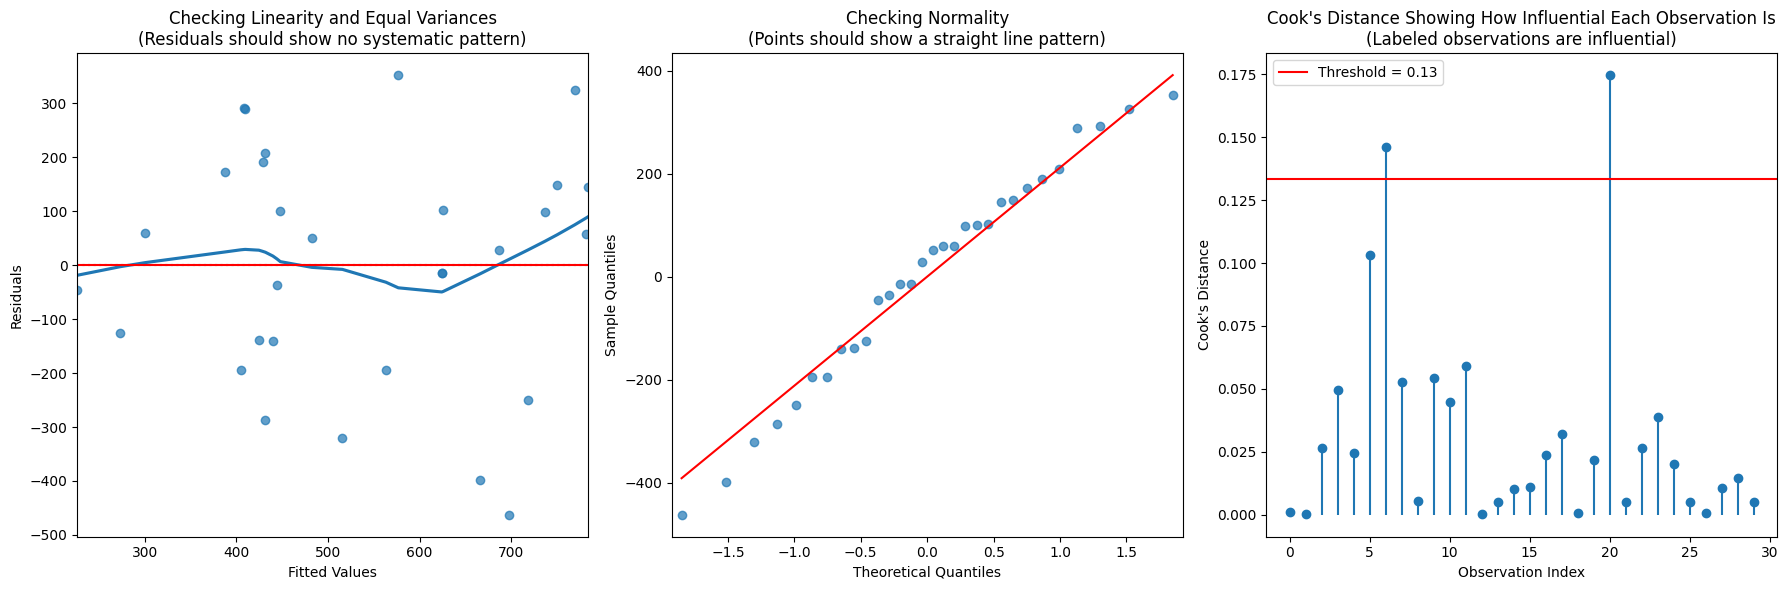

In [8]:
# @title
check_line_assumptions (model_q1)

In the first graph, we can see the blue fitted line stays relatively close to 0, except near the end where it begins to increase. The spread of values also seems to form a cone shape, where the spread increases toward the right side of the graph. This could indicate minor issues with equal variance. The second graph shows a series of points that closely fit the straight line, so normality is not a likely issue. Finally, the third graph shows 2 points above the threshold, which indicates that they are influential. These may be potential outliers or mistakes, but it is hard to speculate given the simplicity of the data. Overall, this model has a few minor issues that may impact the validity of our interpretations. The issue of unequal variance and the influential points warrant future investigation.

## (2) Using the data only for California, how does the number of bedrooms of a home influence its price?

We begin by constructing a simple linear regression model using the ordinary least squares method again. This model has one input (beds) and one output (price). A statistical summary of the model is then computed below.

In [9]:
# @title
model_q2 = ols("Price ~ Beds", data=dataset_ca).fit()
print("(2) Regression of price on beds (California only)\n")
print(model_q2.summary())

(2) Regression of price on beds (California only)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.352
Date:                Tue, 10 Dec 2024   Prob (F-statistic):              0.255
Time:                        15:42:55   Log-Likelihood:                -209.21
No. Observations:                  30   AIC:                             422.4
Df Residuals:                      28   BIC:                             425.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
I

The coefficient for beds indicates that the price for Californian homes increases by \$84,767.30 for each bedroom. However, the p-value is greater than 0.05, which suggests that the relationship between the number of bedrooms and price is not statistically significant. Indeed, this is reflected by the r-squared value of 0.046, which shows that only 4.6% of the variance in price is explained by the number of bedrooms. It is smaller than the r-squared value for size/price. This model may benefit from data that captures what type of bedrooms the home has. For example, master bedrooms may add more value to a home compared to regular bedrooms.

Next, we check the model to see if it adheres to the LINE assumptions.

/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


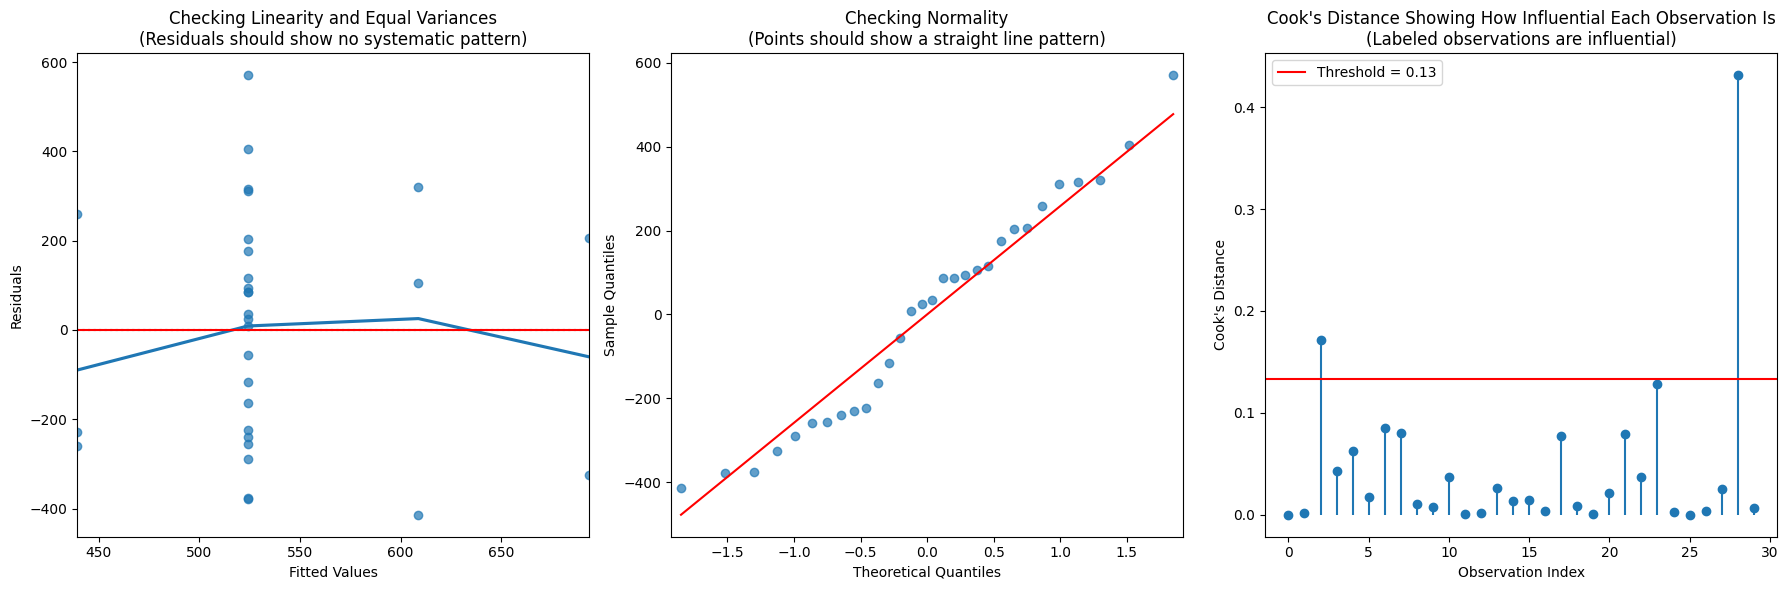

In [10]:
# @title
check_line_assumptions (model_q2)

The first graph shows that most fitted values are concentrated around x = 525, ranging from y = -400 to y = 600. The blue fitted line is reminiscent of a quadratic curve, so the model may have a small issue with linearity. The variance of points in the other parts of the graph seem to differ, but the lack of points makes it hard to tell. The second graph shows a series of points that closely fit the straight line, so normality is not a likely issue. Finally, the third graph shows 2 points above the threshold, which indicates that they are influential. Overall, it seems that this model may not adhere to some of the LINE assumptions, and may not accurately reflect the relationships present in the data. However, the issues are realtively minor, so it is difficult to be sure.

## (3) Using the data only for California, how does the number of bathrooms of a home influence its price?

Once more, we begin by constructing a simple linear regression model using the ordinary least squares method. This model has one input (baths) and one output (price). A statistical summary of the model is then computed below.

In [11]:
# @title
model_q3 = ols("Price ~ Baths", data=dataset_ca).fit()
print("(3) Regression of price on baths (California only)\n")
print(model_q3.summary())

(3) Regression of price on baths (California only)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     9.779
Date:                Tue, 10 Dec 2024   Prob (F-statistic):            0.00409
Time:                        15:42:56   Log-Likelihood:                -205.43
No. Observations:                  30   AIC:                             414.9
Df Residuals:                      28   BIC:                             417.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


The coefficient for the number of bedrooms is 194.7391, indicating that the price of Californian homes increases by \$194,739.10 for each bathroom they have. In this case, the p-value of 0.004 is less than 0.05, showing that this relationship is statistically significant. However, the r-squared value for this model is relatively low at 0.259, which is even smaller the the r-squared value for the price/size model. Only 25.9% of the variance in price is explained by the number of bathrooms. Once again, this indicates that this value alone may not be enough to accurately predict the price. It is also worth noting that the data does not specify what type of bathrooms each house has. For example, some bathrooms have showers, some have tubs, and some have neither. It may be worth exploring how these differences affect the price.

Next, we check the model to see if it adheres to the LINE assumptions.

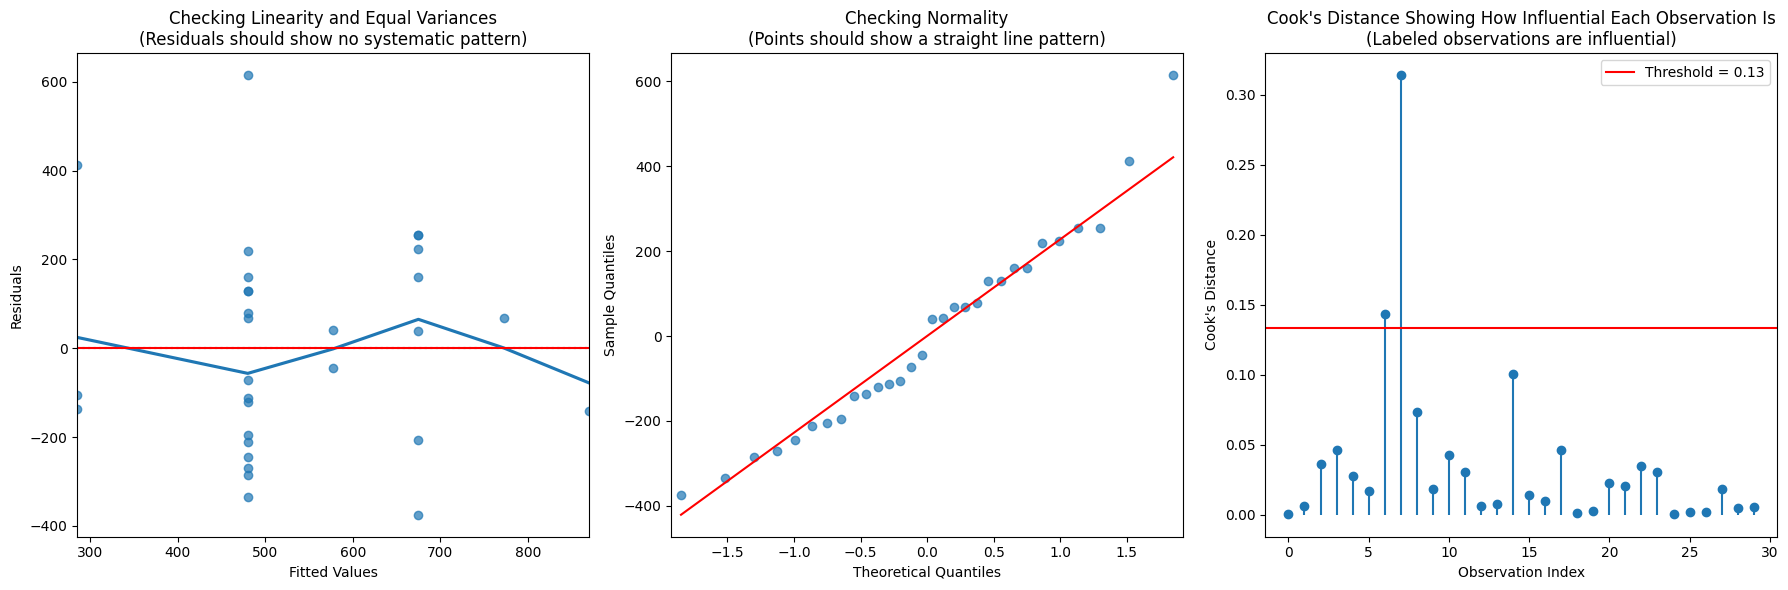

In [12]:
# @title
check_line_assumptions (model_q3)

The first graph shows that many points are clustered around x = 485 and x = 685. The fitted line stays close to 0, indicating that the model likely doesn't have an issue with linearity. Both clusters appear to have similar variances. However, the points between them show less variance, which may be a violation of equal variance and a possible issue for the model. Although, this may just be due to the short length of the dataset. The second graph shows a series of points that closely fit the straight line, so normality is not a likely issue. Finally, the third graph shows 2 points above the threshold,which may be affecting the model's performance. Overall, the model mostly adheres to the LINE assumptions, but its r-squared score indicates that there is room for improvement.

## (4) Using the data only for California, how do the size, the number of bedrooms, and the number of bathrooms of a home jointly influence its price?

Once more, we begin by constructing a multiple linear regression model using the ordinary least squares method. This model has three inputs (size, bedrooms, and baths) and one output (price). A statistical summary of the model is then computed below.

In [13]:
# @title
model_q4 = ols("Price ~ Size + Beds + Baths", data=dataset_ca).fit()
print("(4) Multiple regression of price on size, beds, and baths (California only)\n")
print(model_q4.summary())

(4) Multiple regression of price on size, beds, and baths (California only)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     5.568
Date:                Tue, 10 Dec 2024   Prob (F-statistic):            0.00435
Time:                        15:42:58   Log-Likelihood:                -202.48
No. Observations:                  30   AIC:                             413.0
Df Residuals:                      26   BIC:                             418.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

The model coefficients suggest how size, bedrooms, and baths affect the price of homes in California (assuming the other inputs are held constant):
*   For every 1000 square feet, the price increases by \$281.10 (or ~$0.28 per square foot).
*   For every bedroom, the price decreases by \$33,703.60.
*   For every bathroom, the price increases by \$83,984.40.

However, the p-values indicate that only the size value has a statistically significant relationship with price. The adjusted r-squared value is also only 0.321, which is lower than the score for the price/size model (0.337). This decrease in score suggests that beds and baths may not provide enough explanatory power to the model to justify their inclusion. The results also defy the expectation that adding more bedrooms would increase the price of a home.

Now we compute and show the correlation coefficients for each of the inputs.

In [14]:
# @title
dataset_corr = dataset_ca[['Size', 'Beds', 'Baths']]
corr_matrix = dataset_corr.corr()
print("Correlation matrix for input values\n")
print(corr_matrix)

Correlation matrix for input values

           Size      Beds     Baths
Size   1.000000  0.449014  0.642534
Beds   0.449014  1.000000  0.350188
Baths  0.642534  0.350188  1.000000


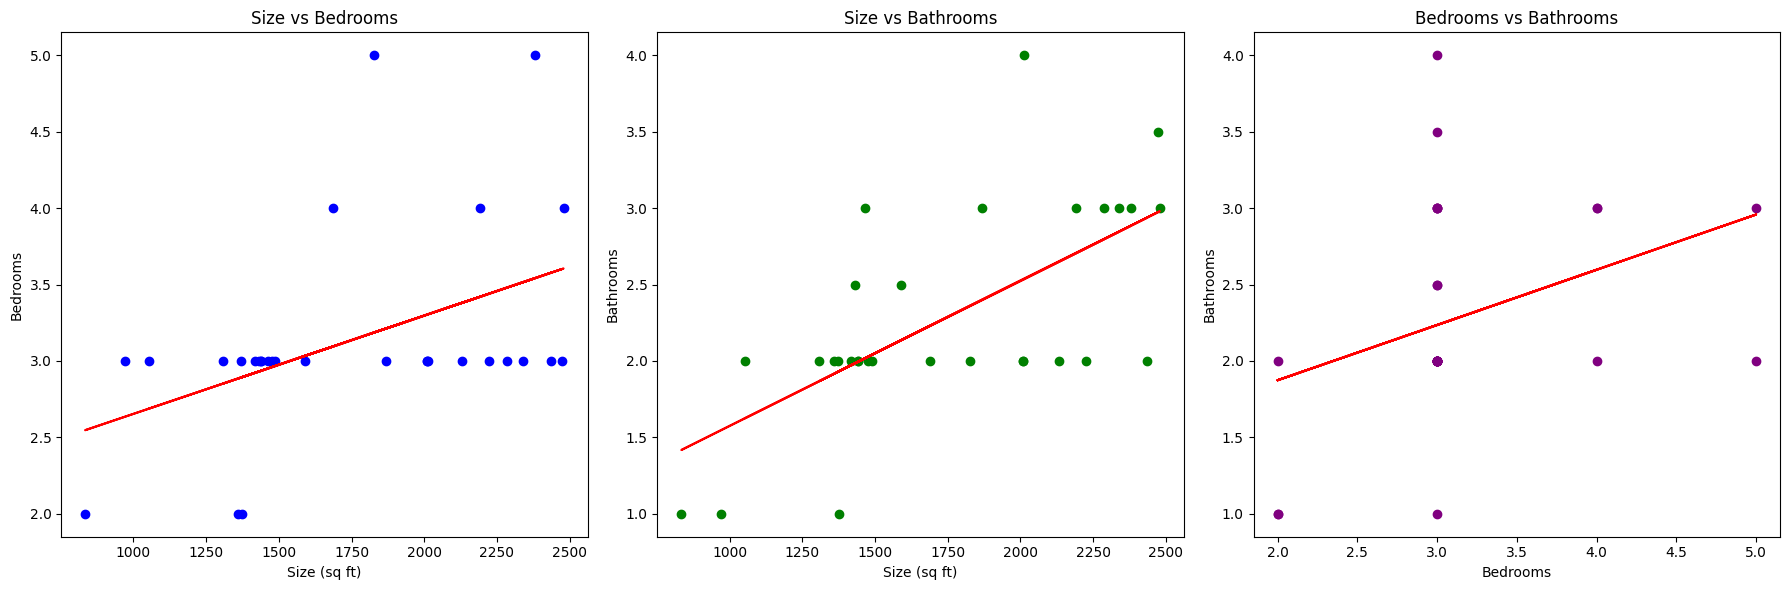

In [15]:
# @title
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # Scatter plot with linear regression line

# Scatter plot for size/beds
x1 = dataset_corr['Size']
y1 = dataset_corr['Beds']
model1 = sm.OLS(y1, sm.add_constant(x1)).fit()

axes[0].scatter(x1, y1, color='blue')
axes[0].plot(x1, model1.predict(sm.add_constant(x1)), color='red')
axes[0].set_xlabel('Size (sq ft)')
axes[0].set_ylabel('Bedrooms')
axes[0].set_title('Size vs Bedrooms')

# Scatter plot for size/baths
x2 = dataset_corr['Size']
y2 = dataset_corr['Baths']
model2 = sm.OLS(y2, sm.add_constant(x2)).fit()

axes[1].scatter(x2, y2, color='green')
axes[1].plot(x2, model2.predict(sm.add_constant(x2)), color='red')
axes[1].set_xlabel('Size (sq ft)')
axes[1].set_ylabel('Bathrooms')
axes[1].set_title('Size vs Bathrooms')

# Scatter plot for beds/baths(/beyond)
x3 = dataset_corr['Beds']
y3 = dataset_corr['Baths']
model3 = sm.OLS(y3, sm.add_constant(x3)).fit()

axes[2].scatter(x3, y3, color='purple')
axes[2].plot(x3, model3.predict(sm.add_constant(x3)), color='red')
axes[2].set_xlabel('Bedrooms')
axes[2].set_ylabel('Bathrooms')
axes[2].set_title('Bedrooms vs Bathrooms')

# Render the graphss
plt.tight_layout()
plt.show()

All three inputs show positive correlations with each other. The results indicate a strong correlation between size and the number of bedrooms, a moderate correlation between size and the number of bathrooms, and a weak correlation between the number of bedrooms and bathrooms. This suggests that the model may have an issue with multicollinearity (especially with size and the number of bathrooms), which could explain why its adjusted r-squared score decreased compared to the price/size model.

Next, we check the model to see if it adheres to the LINE assumptions.

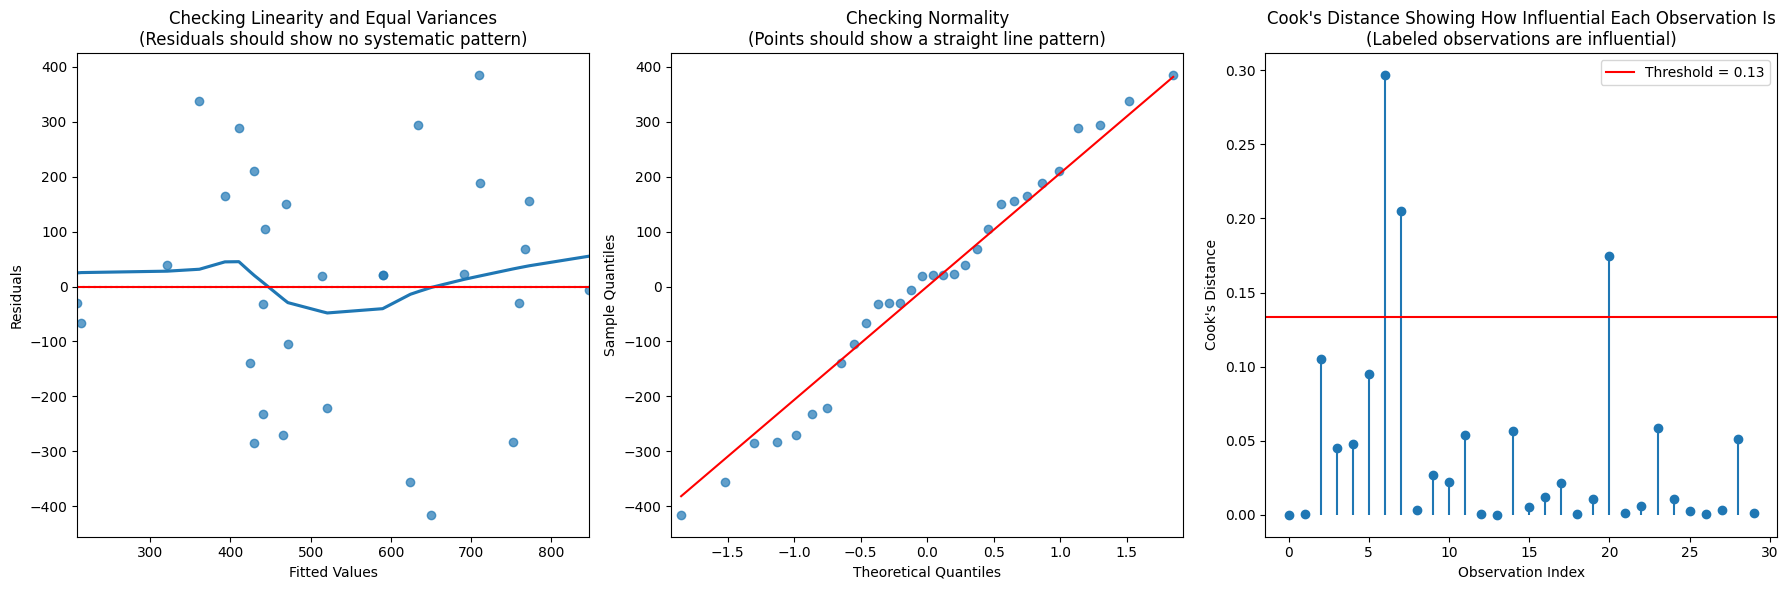

In [16]:
# @title
check_line_assumptions (model_q4)

The first graph shows that the points are relatively evenly distributed and that the points are randomly distributed around 0. The blue fitted line also stays relatively close to 0. The second graph shows a series of points that closely fit the straight line, so normality is not a likely issue either. Finally, the third graph shows 3 points above the threshold, which indicates that they are influential. This is more than any of the previous models. Given the poor performance of this model relative to the price/size model, it may be worth investigating these points further to understand how they affect the model. Overall, it seems like the model adheres to the LINE assumptions, although its r-squared score indicates that the selected predictors are not effective. The impact of the influential points on the performance of the model should also be investigated. This could reveal new patterns in the data and aid in constructing a better model.

## (5) Are there significant differences in home prices among the four states (CA, NY, NJ, PA)? This will help you determine if the state in which a home is located has a significant impact on its price. All data should be used.

First, let's take a look at the mean price for homes in each state.

In [17]:
# @title
mean_prices = dataset.groupby('State')['Price'].mean()

print("Mean Price for each State:")
print(mean_prices)

Mean Price for each State:
State
CA    535.366667
NJ    328.533333
NY    365.333333
PA    265.566667
Name: Price, dtype: float64


We can see some large differences here, but we need to test them to be sure they're significant. For this, we will use ANOVA to determine whether the price of a home is different depending on the state it's in. A summary of the results can be found below.

In [18]:
# @title
model_q5 = ols("Price ~ State", data=dataset).fit()
anova_table = sm.stats.anova_lm(model_q5, typ=2)
print("(5) ANOVA for price differences across states\n")
print(anova_table)

(5) ANOVA for price differences across states

                sum_sq     df         F    PR(>F)
State     1.198169e+06    3.0  7.354696  0.000148
Residual  6.299266e+06  116.0       NaN       NaN


The p-value is smaller than 0.05, which provides strong evidence that the price of homes in at least one state is significantly different. To find which states are not equal, we perform a post-hoc Tukey's HSD test.

In [19]:
# @title
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_result = pairwise_tukeyhsd(endog=dataset['Price'], groups=dataset['State'], alpha=0.05)
print(tukey_result.summary())

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
    CA     NJ -206.8333 0.0045 -363.6729  -49.9938   True
    CA     NY -170.0333  0.028 -326.8729  -13.1938   True
    CA     PA    -269.8 0.0001 -426.6395 -112.9605   True
    NJ     NY      36.8 0.9282 -120.0395  193.6395  False
    NJ     PA  -62.9667 0.7225 -219.8062   93.8729  False
    NY     PA  -99.7667 0.3506 -256.6062   57.0729  False
---------------------------------------------------------


The results show significant differences between California and the other three states. Since all the results are negative, it shows that California generally has higher housing prices than the other states, with Pennsylvania having the largest difference. However, the other states do not have large enough p-values to suggest significant differences between them.

Next, we check the ANOVA model to see if it adheres to the LINE assumptions.

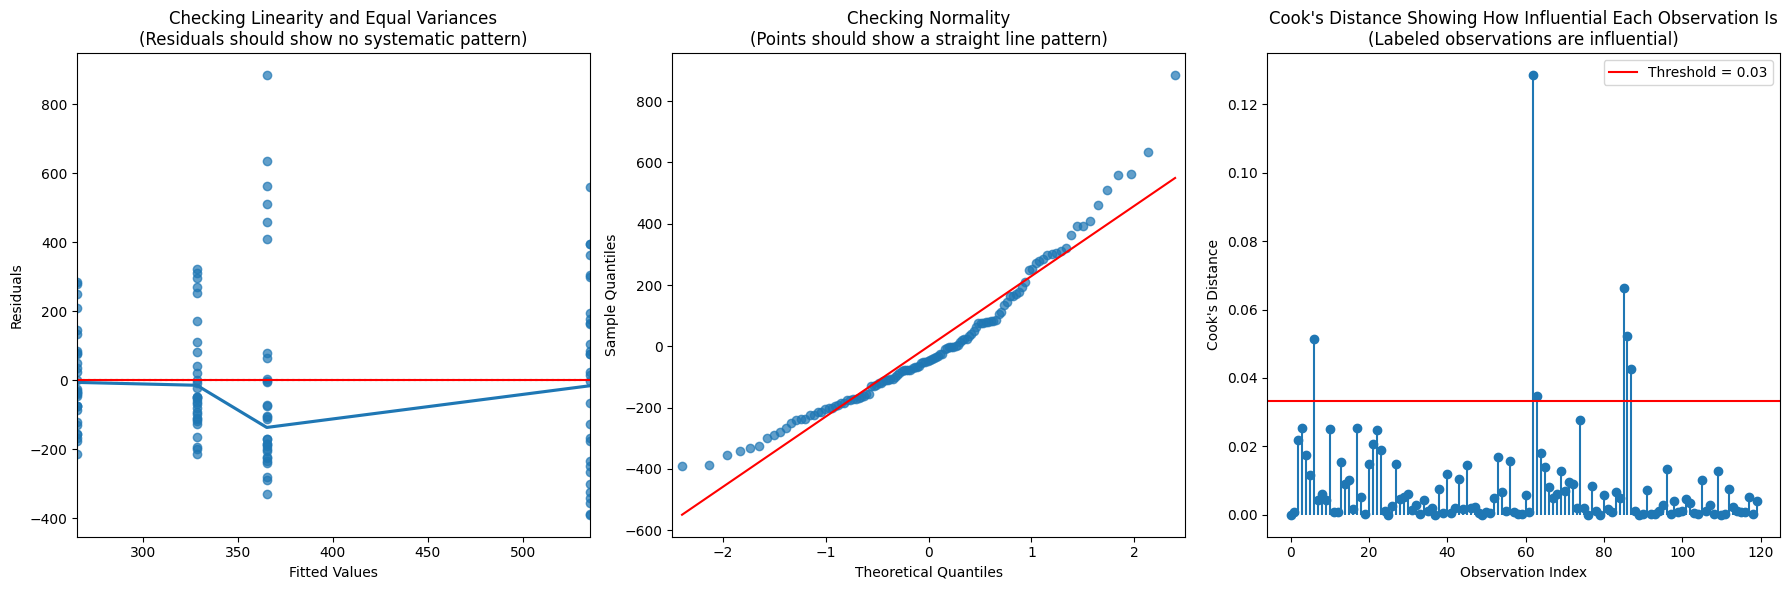

In [20]:
# @title
check_line_assumptions (model_q5)

The first graph shows that the points are clustered vertically around 4 parts of the graph. The blue fitted line is somewhat flat, but most of it appears lower than 0, suggesting a possible issue with linearity. The distribution of values also seems to peak around the center of the graph, indicating a possible problem with equal variance as well. The points on the second graph show a slight upward curve that suggests the model violates the assumption of normality. Finally, the third graph shows that the model has 6 outliers, although this may be because the model simply has more data. Overall, these possible violations of the LINE assumptions suggest that the results of the ANOVA test should be interpreted and accepted with caution.

# Summary

This report summarizes our findings from the analysis of housing data from California, New York, New Jersey, and Pennsylvania. Below is a summary of our findings and interpretations for each question.

*   **(1) Impact of size on price (CA):** The price of Californian homes increases by \$339.20 for every 1000 square feet. The model shows that this result is significant, but the r-squared value indicates that it's possibly not the only important factor.

*   **(2) Impact of the number of bedrooms on price (CA):** The price of Californian homes increases by \$84,767.30 for every bedroom it has. However, the model shows that this result is not significant. Also, the r-squared value suggests that only a small amount of variance in price is explained by the number of bedrooms.

*   **(3) Impact of the number of bathrooms on price (CA):** The price of Californian homes increases by \$194,739.10 for every bathroom it has. The model shows that this result is significant, although the r-squared value suggests that other factors may influence price as well.

*   **(4) Impact of size, number of bedrooms, and number of bathrooms on price (CA):** The model suggests that the price of Californian homes increases by \$281.10 for every 1000 square feet, decreases by \$33,703.60 for every bedroom, and increases by \$83,984.40 for every bathroom. However, only the size input seems to have a statistically significant relationship with price. Analysis of the correlations between the inputs suggests the model may have issues with multicollinearity.

*   **(5) Possible significant differences in home prices among the four states (CA, NY, NJ, PA):** The ANOVA test indicates that there is at least one state with a significant price difference. Analysis of a post-hoc test indicates that California has a higher mean price compared to the other three states.

This project sheds some light on a few factors affecting housing prices in California. Of the three factors we tested, square footage seemed to be the best predictor of price. This indicates that more data may be needed to create a more effective model and that it may benefit from data with more detail (such as specifying the bathroom type). Since the data also indicates that Californian housing prices are greater than in other states, it would be good to investigate what factors make California's situation unique. Overall, this data may help us better understand the housing market and make decisions regarding zoning, population management, and the economy.

# References

Lock, R., Lock, P., Morgan, K., Lock, E., & Lock, D. (2020). HomesForSale [Dataset]. https://www.lock5stat.com/datapage3e.html

Lock, R., Lock, P., Morgan, K., Lock, E., & Lock, D. (2020). Dataset documentation for the third edition of “Statistics: UnLocking the Power of Data.” Wiley. https://www.lock5stat.com/datasets3e/Lock5DataGuide3e.pdf